## Travaux Visu

In [1]:
import numpy as np
import pandas as pd

from bokeh.io import output_file, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.io import output_notebook
from bokeh.models.widgets import Panel, Tabs
from bokeh.models import DatetimeTickFormatter
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

FILE_PATH = 'clean_data/data_clean.csv'
FILE_PATH_METEO = 'clean_data/data_meteo_prod.csv'
FILE_PATH_MOIS = 'clean_data/data_clean_by_month.csv'
FILE_PATH_JOURS = 'clean_data/data_clean_by_days.csv'

Loading BokehJS ...

In [2]:
df = pd.read_csv(FILE_PATH, sep=',')
df_meteo = pd.read_csv(FILE_PATH_METEO, sep=',')
df_prod_mois = pd.read_csv(FILE_PATH_MOIS, sep=',')
df_prod_jours = pd.read_csv(FILE_PATH_JOURS, sep = ',')

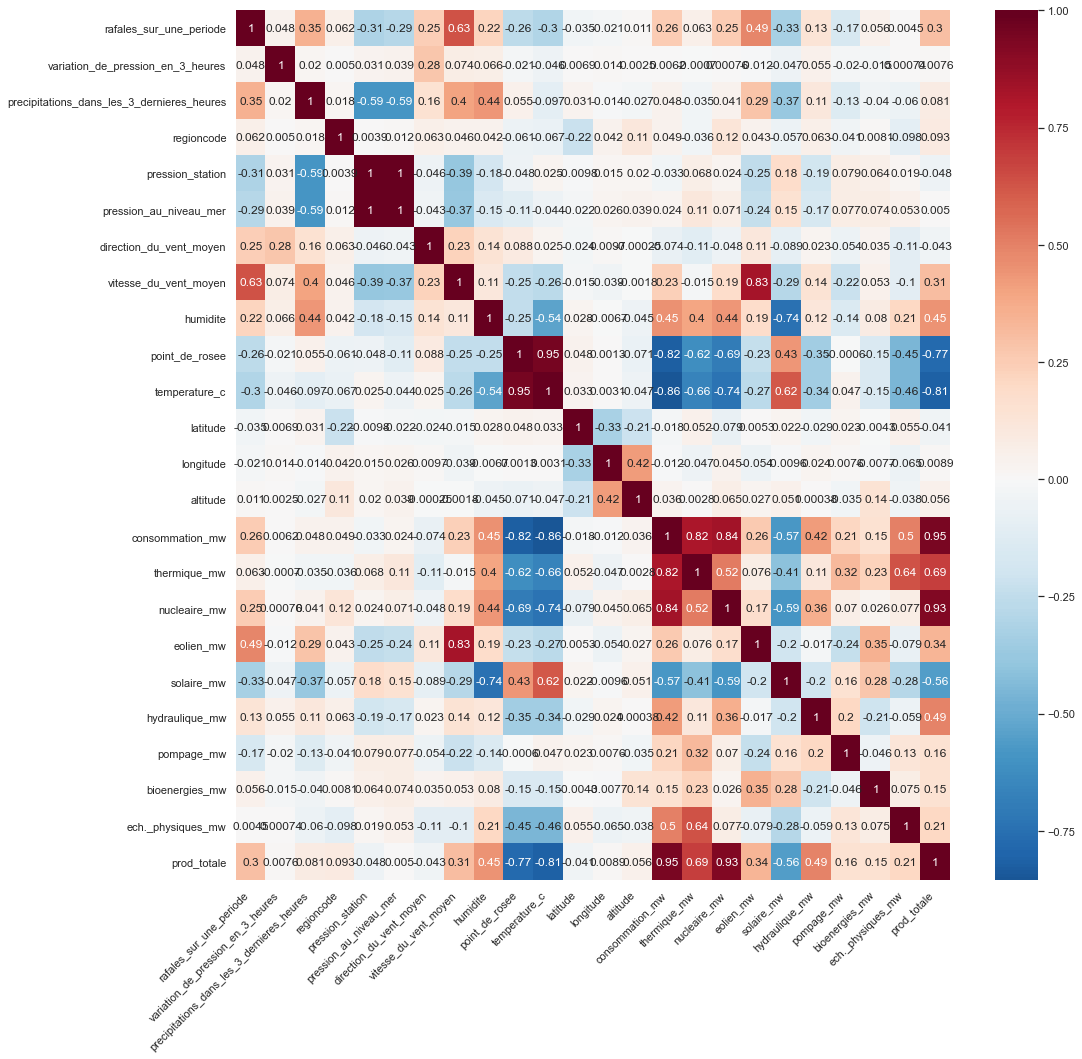

In [3]:
plt.figure(figsize=(16,16))

g = sns.heatmap(df_meteo.corr(), annot = True, center=0, cmap = 'RdBu_r')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');
 

On remarque une corrélation forte entre la production du nucleaire et la production totale.
La consommation semble légèrement corrélé avec d'autre variable, mais il ne semble pas exister une variable explicative fortement corrélé à celle-ci.

Nous notons **une correlation potentiellement exploitable entre la production Hydraulique et la pression atmosphérique mesuré et la pression au niveau de la mer**.

Concernant la consommation, il semble y avoir 2 variables légèrement corrélées (bioenergie et hydraulique)

La température est corrélé à seulement 0.36 avec la consommation, est-ce exploitable ? à tester

Quelle est la proportion de chaque filière dans la production totale chaque année ?

In [4]:
df_year = df.groupby('year').sum()
df_year = df_year.drop(['code_insee_region', 'month', 'days'], axis=1)

In [5]:
def viz(doc):
    def update(attr,old,new):        
        df_pie = grabData(new)
        src.data.update(ColumnDataSource(df_pie).data)

    def grabData(year):
        df_pie = df_year.T
        df_pie = df_pie.drop(['consommation_mw', 'pompage_mw', 'ech._physiques_mw', 'prod_totale'])
        df_pie = df_pie[year].to_frame()
        df_pie = df_pie.rename({year : 'value'}, axis=1)

        df_pie['angle'] = df_pie['value']/df_pie['value'].sum() * 2*np.pi
        df_pie['prop'] = df_pie['value']/df_pie['value'].sum() *100
        df_pie['color'] = ["#A491D3","#818AA3","#C5DCA0", "#F5F2B8", "#F9DAD0", "#7D6D68"]
        return df_pie

    df_pie = grabData(2013)
    src = ColumnDataSource(df_pie)

    p = figure(plot_height=350, 
               title="Proportion des filières par Année en %", 
               toolbar_location=None,
               tools="hover", 
               tooltips="@index: @prop",
               x_range=(-0.5, 1.0),)

    p.wedge(source=src,x=0, y=1, radius=0.4,
        start_angle= cumsum('angle', include_zero=True), 
        end_angle=cumsum('angle'),
        line_color="white", 
        fill_color='color',
        legend_field='index',)
    
    p.axis.axis_label = None
    p.axis.visible = False
    p.grid.grid_line_color = None

    slider = Slider(start=2013, end=2019, value=2013, step=1, title="Année")
    slider.on_change('value',update)
    doc.add_root(column(p,slider))

show(Application(FunctionHandler(viz)))

Le graphique répond à la question précédente. La filière du nucléaire réprésente plus de 70% de la production d'electricité en france au fil des années. 
Nous pouvons voir que la tendance est au recul pour laisser une place (grandissante) aux autres filières, surtout l'eolien.

Désormais, place à la temporalité de la production & de la consommation.

In [6]:
### PREPROCESS ###
df['annee_mois']=df['year'].astype(str)+ '-' +df['month'].astype(str)

df_mois = df.groupby('annee_mois', as_index=False).sum()

df_mois['annee_mois'] = pd.to_datetime(df_mois['annee_mois'])

df_mois = df_mois.sort_values(by=['annee_mois'])

df_mois = df_mois.iloc[0:84,:]

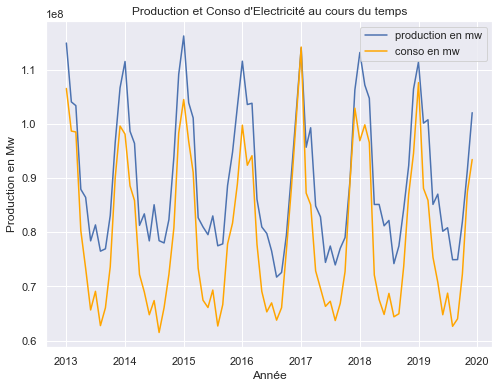

In [7]:
### Plotting ###

plt.figure(figsize=(8,6))
plt.plot(df_mois['annee_mois'], df_mois['prod_totale'], label = 'production en mw')
plt.plot(df_mois['annee_mois'], df_mois['consommation_mw'], label = 'conso en mw', color='orange')
plt.xlabel('Année')
plt.ylabel('Production en Mw')
plt.legend()
plt.title('Production et Conso d\'Electricité au cours du temps');


Il semble y avoir **un effet de saisonnalité** dans la production & la consommation d'energie. Nous souhaitons zoomer dans chaque année afin de mieux comprendre le phénomène mois par mois. 

In [8]:
df_prod_jours['date'] = df_prod_jours['year'].astype(str)+'-'+df_prod_jours['month'].astype(str)+'-'+df_prod_jours['days'].astype(str)
df_prod_jours['date'] =  pd.to_datetime(df_prod_jours['date'])

df_annee = {}
l_ann = np.arange(2013,2020,1)
for annee in l_ann:
    df_annee["df{0}".format(annee)] = df_prod_jours[df_prod_jours['year']==annee]


#df_annee['df2019']  #pour appeler le tableau de l'année


In [9]:
annee = ['df2013', 'df2014', 'df2015', 'df2016', 'df2017', 'df2018', 'df2019']
p1 = figure(plot_width = 800, plot_height = 600, title = 'Production & Consommation en 2013')
p2 = figure(plot_width = 800, plot_height = 600, title = 'Production & Consommation en 2014')
p3 = figure(plot_width = 800, plot_height = 600, title = 'Production & Consommation en 2015')
p4 = figure(plot_width = 800, plot_height = 600, title = 'Production & Consommation en 2016')
p5 = figure(plot_width = 800, plot_height = 600, title = 'Production & Consommation en 2017')
p6 = figure(plot_width = 800, plot_height = 600, title = 'Production & Consommation en 2018')
p7 = figure(plot_width = 800, plot_height = 600, title = 'Production & Consommation en 2019')
l_p = [p1, p2, p3, p4, p5, p6, p7]


for p, a in zip(l_p, annee):
    p.line(df_annee[a]['date'], df_annee[a]['prod_totale'], legend_label = 'production' )
    p.line(df_annee[a]['date'], df_annee[a]['consommation_mw'], color = 'orange', legend_label = 'consommation')

    p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )
    p.xaxis.major_label_orientation = np.pi/4



tab1 = Panel(child = p1, title = '2013')
tab2 = Panel(child = p2, title = '2014')
tab3 = Panel(child = p3, title = '2015')
tab4 = Panel(child = p4, title = '2016')
tab5 = Panel(child = p5, title = '2017')
tab6 = Panel(child = p6, title = '2018')
tab7 = Panel(child = p7, title = '2019')


l_tabs = [tab1, tab2, tab3, tab4, tab5, tab6, tab7]    

tabs = Tabs (tabs = l_tabs)


show(tabs)

Grâce à ce graphique nous **confirmons un effet de saisonnalité chaque année !**. Cela nous permet également de remarquer qu'il semble exister un effet de saisonnalité plus poussé (par mois)  
Afin de nous en rendre compte, augmentons encore une fois la granularité de notre étude. **Nous prendrons 2019 pour exemple.**

In [10]:
df_mois = {}
l_mois = np.arange(1,13,1)
for mois in l_mois:
    df_mois["df{0}".format(mois)] = df_annee['df2019'][df_annee['df2019']['month']==mois]

#df_mois['df1'] #pour appeler le tableau du mois

In [11]:
mois = ['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9', 'df10', 'df11', 'df11', 'df12']
p1 = figure(plot_width = 800, plot_height = 600, title = 'Janvier 2019')
p2 = figure(plot_width = 800, plot_height = 600, title = 'Fevrier 2019')
p3 = figure(plot_width = 800, plot_height = 600, title = 'Mars 2019')
p4 = figure(plot_width = 800, plot_height = 600, title = 'Avril 2019')
p5 = figure(plot_width = 800, plot_height = 600, title = 'Mai 2019')
p6 = figure(plot_width = 800, plot_height = 600, title = 'Juin 2019')
p7 = figure(plot_width = 800, plot_height = 600, title = 'Juillet 2019')
p8 = figure(plot_width = 800, plot_height = 600, title = 'Août 2019')
p9 = figure(plot_width = 800, plot_height = 600, title = 'Septembre 2019')
p10 = figure(plot_width = 800, plot_height = 600, title = 'Octobre 2019')
p11 = figure(plot_width = 800, plot_height = 600, title = 'Novembre 2019')
p12 = figure(plot_width = 800, plot_height = 600, title = 'Décembre 2019')

l_p = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12]


for p, m in zip(l_p, mois):
    p.line(df_mois[m]['date'], df_mois[m]['prod_totale'], legend_label = 'production' )
    p.line(df_mois[m]['date'], df_mois[m]['consommation_mw'], color = 'orange', legend_label = 'consommation')

    p.xaxis.formatter=DatetimeTickFormatter(
        hours=["%d %B %Y"],
        days=["%d %B %Y"],
        months=["%d %B %Y"],
        years=["%d %B %Y"],
    )
    p.xaxis.major_label_orientation = np.pi/4



tab1 = Panel(child = p1, title = 'Jan-19')
tab2 = Panel(child = p2, title = 'Fev-19')
tab3 = Panel(child = p3, title = 'Mar-19')
tab4 = Panel(child = p4, title = 'Avr-19')
tab5 = Panel(child = p5, title = 'Mai-19')
tab6 = Panel(child = p6, title = 'Jui-19')
tab7 = Panel(child = p7, title = 'Juil-19')
tab8 = Panel(child = p8, title = 'Aou-19')
tab9 = Panel(child = p9, title = 'Sep-19')
tab10 = Panel(child = p10, title = 'Oct-19')
tab11 = Panel(child = p11, title = 'Nov-19')
tab12 = Panel(child = p12, title = 'Dec-19')

l_tabs = [tab1, tab2, tab3, tab4, tab5, tab6, tab7, tab8, tab9, tab10, tab11, tab12]    

tabs = Tabs (tabs = l_tabs)


show(tabs)

**La production et la consommation semble se suivre de manière cyclique, hypothèse confimée** lorsque l'on zoom dans une année!